In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from matplotlib.lines import Line2D
import qinfer as qi
from scipy import linalg
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.markers as mmark
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from lfig import LatexFigure
sys.path.append("/home/bf16951/QMD")
import qmla
import matplotlib
%matplotlib inline

In [2]:
def load_results(
    results_time,
    results_folder=os.path.abspath("/home/bf16951/thesis/qmla_run_data/local/"),
    run_id='001'
):

    results_dir = os.path.join(
        results_folder, 
        results_time
    )

    try:
        results_file = os.path.join(results_dir, 'results_{}.p'.format(run_id))
        res = pickle.load(open(results_file, 'rb'))
    except:
        results_file = os.path.join(results_dir, 'results_m1_q{}.p'.format(run_id))
        res = pickle.load(open(results_file, 'rb'))


    try:
        true_params = pickle.load(open(os.path.join(results_dir, 'run_info.p'), 'rb')) 
    except:
        true_params = pickle.load(open(os.path.join(results_dir, 'true_params.p'), 'rb')) 
        
    qmla_class_file = os.path.join(results_dir, 'qmla_class_{}.p'.format(run_id))
    plot_probes = pickle.load(open(os.path.join(results_dir, 'plot_probes.p'), 'rb'))
    true_measurements = pickle.load(open(os.path.join(results_dir, 'system_measurements.p'), 'rb'))
    q = pickle.load(open(qmla_class_file, 'rb'))
    try:
        q2 = pickle.load(open(os.path.join(results_dir, 'qmd_class_002.p'), 'rb'))
    except:
        pass
    es = q.exploration_class
    try:
        combined_datasets = os.path.join(results_dir, 'combined_datasets')
        evaluation_data = pickle.load(open(os.path.join(results_dir, 'evaluation_data.p' ), 'rb'))
        storage = pickle.load(open(os.path.join(results_dir, 'storage_{}.p'.format(run_id)), 'rb'))
        system_probes = pickle.load(open(
            os.path.join(results_dir, 'training_probes', 'system_probes.p'),
            'rb'
        ))
        ga = gr.genetic_algorithm
    except:
        pass

    try:
        # these are only available if analysis has been performed
        champ_info = pickle.load(open(os.path.join(results_dir, 'champion_models',  'champions_info.p' ), 'rb'))
        bf = pd.read_csv(os.path.join(combined_datasets,  'bayes_factors.csv' ))
        fitness_df = pd.read_csv(os.path.join(combined_datasets,  'fitness_df.csv' ))
        combined_results = pd.read_csv(os.path.join(results_dir, 'combined_results.csv'))
        correlations = pd.read_csv(
            os.path.join(combined_datasets, "fitness_correlations.csv")
        )
        fitness_by_f_score = pd.read_csv(
            os.path.join(combined_datasets, 'fitness_by_f_score.csv')
        )
    except:
        pass
    
    results = {
        'qmla_instance' : q, 
        'exploration_strategy' : es, 
        'results_dir' : results_dir,
        'true_measurements' : true_measurements, 
        'true_params' : true_params
    }
    
    return results

# run with lattices

In [3]:
model_name_to_lattice_idx_map = {
    'pauliLikewise_lx_1_2_d2+pauliLikewise_lz_1J2_d2' : 'a', # 2 chain
    'pauliLikewise_lx_1_2_3_d3+pauliLikewise_lz_1J2_2J3_d3' : 'b', # 3 chain
    'pauliLikewise_lx_1_2_3_d3+pauliLikewise_lz_1J2_1J3_2J3_d3' : 'c', # triangle 
    'pauliLikewise_lx_1_2_3_4_d4+pauliLikewise_lz_1J2_1J3_1J4_2J3_2J4_3J4_d4' : 'd', # 4 full
    'pauliLikewise_lx_1_2_3_4_d4+pauliLikewise_lz_1J2_1J3_2J4_3J4_d4' : 'e', # 4 square

    'pauliLikewise_lx_1_2_3_4_d4+pauliLikewise_lz_1J2_2J3_3J4_d4' : 'f', # 4 chain
    'pauliLikewise_lx_1_2_3_4_5_d5+pauliLikewise_lz_1J2_2J3_3J4_4J5_d5' : 'g', # 5 chain
    'pauliLikewise_lx_1_2_3_4_5_6_d6+pauliLikewise_lz_1J2_2J3_3J4_4J5_5J6_d6' : 'h', # 6 chain
    'pauliLikewise_lx_1_2_3_4_5_d5+pauliLikewise_lz_1J2_1J3_1J4_1J5_2J3_2J4_2J5_3J4_3J5_4J5_d5' : 'i', # 5 full
    'pauliLikewise_lx_1_2_3_4_5_6_d6+pauliLikewise_lz_1J2_1J3_2J4_2J5_3J4_4J6_5J6_d6' : 'j', # 6 grid
}
get_idx = lambda x: model_name_to_lattice_idx_map[x]
lattice_indices = [chr(ord('`')+ (i) ) for i in range(1, 11)]

In [4]:
run = "Nov_19/12_04"
results = load_results(
    run,
    results_folder=os.path.abspath("/home/bf16951/thesis/qmla_run_data/"),
    run_id='001'
)
q = results['qmla_instance']
es = results['exploration_strategy']
results_dir = results['results_dir']

In [7]:
es

In [47]:
m = q.get_model_storage_instance_by_id(1)

In [51]:
q.branches[1].bayes_points

{1: 4, 2: 5, 3: 7, 4: 6, 5: 8, 6: 2, 7: 0, 8: 2, 9: 9, 10: 2}

In [11]:
bfs = [
    q.model_database[
            q.model_database.lattice_idx == l
        ].bf_points.values[0]
    for l in lattice_indices
]


AttributeError: 'DataFrame' object has no attribute 'bf_points'

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


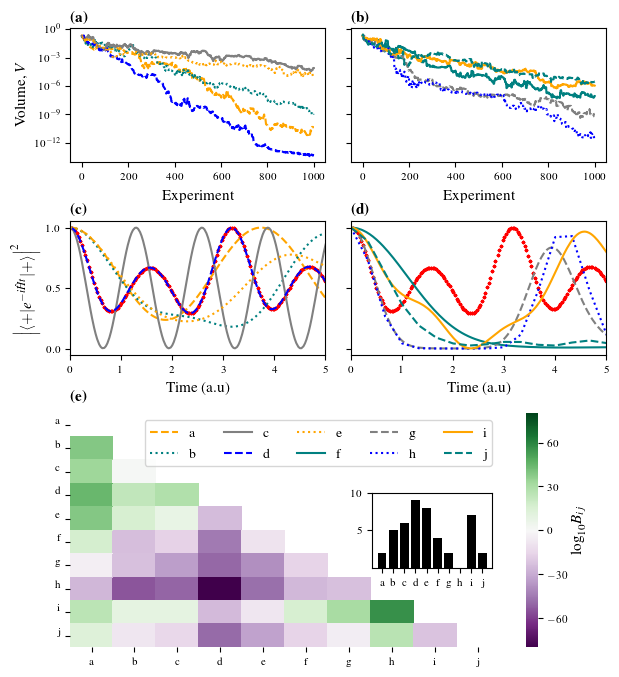

In [61]:
colourmap = plt.cm.tab10
get_colour = lambda x: colourmap(x/10)
q.model_database['lattice_idx'] = q.model_database.model_name.apply(get_idx)
q.model_database['colour'] = q.model_database.model_id.apply(get_colour)

colours_to_use = itertools.cycle(iter(['orange', 'teal', 'grey', 'blue']))
linestyles = itertools.cycle(iter(['--', ':',  '-']))
get_colour_linestyle = lambda: (next(colours_to_use), next(linestyles))

lf = LatexFigure(
    gridspec_layout=(3,2), 
    gridspec_params = {
        "height_ratios" : [1,1,1.75],
        "hspace" : 0.35,
        "wspace" : 0.1
    }
)
vol_ax_left = lf.new_axis()
vol_ax_right = lf.new_axis(ax_params = {'sharey' : vol_ax_left})
dynamics_ax_left = lf.new_axis()
dynamics_ax_right = lf.new_axis(ax_params = {'sharey' : dynamics_ax_left})
bf_heatmap_ax = lf.new_axis(span = (1,2))

exp_times = sorted(q.experimental_measurements.keys())
true_msmsts = [q.experimental_measurements[t] for t in exp_times]

bf_points_by_lattice = {}
for lattice_idx in lattice_indices:
    mid = q.model_database[
        q.model_database.lattice_idx == lattice_idx
    ].model_id.unique()[0]
    colour = get_colour(mid)
    model = q.get_model_storage_instance_by_id(mid)
    
    c, l = get_colour_linestyle()
    lattice_idx = get_idx(model.name)
    
    if lattice_idx in ['a', 'b', 'c', 'd', 'e']:
        vol_ax = vol_ax_left
        dynamics_ax = dynamics_ax_left
    else:
        vol_ax = vol_ax_right
        dynamics_ax = dynamics_ax_right   
        
    bf_points_by_lattice[lattice_idx] = q.branches[1].bayes_points[mid]
    
    epochs = sorted(model.volume_by_epoch.keys())
    volume = [model.volume_by_epoch[e] for e in epochs]
    
    vol_ax.plot(
        epochs, 
        volume, 
        label=r"{}".format(lattice_idx), 
        c = c, 
        ls = l
    )
    vol_ax.set_xlabel("Experiment")
    
    times = sorted(model.expectation_values.keys())
    dynamics = [model.expectation_values[t] for t in times]
    dynamics_ax.plot(
        times, 
        dynamics, 
        label = r"{}".format(lattice_idx),
        color = c, 
        ls = l, 
    )
    dynamics_ax.scatter(
        exp_times, 
        true_msmsts, 
        s = 2, 
        c = 'red',        
    )
    dynamics_ax.set_xlim(0,5)    
    dynamics_ax.set_xlabel("Time (a.u)")

# h1, l1 = vol_ax_left.get_legend_handles_labels()
# h2, l2 = vol_ax_right.get_legend_handles_labels()
# h1.extend(h2)
# l1.extend(l2)

vol_ax_right.semilogy()
vol_ax_left.semilogy()
    
q.bayes_factors_df['lattice_a'] = q.bayes_factors_df.model_a.apply(get_idx)
q.bayes_factors_df['lattice_b'] = q.bayes_factors_df.model_b.apply(get_idx)

bayes_factor_by_f_score = pd.pivot_table(
    q.bayes_factors_df, 
    values='log10_bayes_factor', 
    index=['lattice_a'], 
    columns=['lattice_b'],
    aggfunc=np.median
)
    
mask = np.tri(bayes_factor_by_f_score.shape[0], k=0).T
sns.heatmap(
    bayes_factor_by_f_score,
    cmap=matplotlib.cm.PRGn, # TODO get from GR?,
    mask = mask,
    ax = bf_heatmap_ax,
    cbar_kws={'label': r"$\textrm{log}_{10}B_{ij}$"}
)
plt.setp(
    bf_heatmap_ax.get_yticklabels(), 
    rotation=0, 
    ha="right",
    rotation_mode="anchor"
)
bf_heatmap_ax.set_ylabel('')
bf_heatmap_ax.set_xlabel('')

# Bayes factor points inset plot

bf_scores = [bf_points_by_lattice[l] for l in lattice_indices]

inset_ax = inset_axes(
    bf_heatmap_ax, 
    width=1.2, 
    height=0.75, 
    loc='center right'
)
inset_ax.bar(
    lattice_indices, 
    bf_scores, 
#     width=0.5, 
    color = 'black'
)
inset_ax.set_ylim(0,10)
inset_ax.set_yticks([5,10])


vol_ax_left.set_ylabel(r"Volume, $V$")
# vol_ax_right.set_yticks([])
plt.setp(vol_ax_right.get_yticklabels(), visible=False)
plt.setp(dynamics_ax_right.get_yticklabels(), visible=False)

dynamics_ax_left.set_ylabel(r"$\left| \langle + | e^{-i\hat{H}t} | + \rangle \right|^2$")
dynamics_ax_left.set_yticks([0, 0.5, 1])
# dynamics_ax_right.set_yticks([])
dynamics_ax_left.set_xlim(0,5)
dynamics_ax_right.set_xlim(0,5)

hl = {}
for vax in [vol_ax_left, vol_ax_right]:
    h, l = vax.get_legend_handles_labels()
    hl.update( dict(zip(l, h)) )

labels = sorted(hl.keys())
handles = [hl[l] for l in labels]

bf_heatmap_ax.legend(handles, labels, ncol=5)

lf.fig.tight_layout()
lf.save(
    os.path.join(results["results_dir"], "lattice_qmla_summary.pdf")
)
lf.save(
    os.path.join("..", "theoretical_study", "figures", "lattice_qmla_summary.pdf")
)
    